In [ ]:
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from torch_geometric.utils import to_networkx, negative_sampling, to_dense_adj
from torch_geometric.datasets import KarateClub

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
data = KarateClub()[0]

In [3]:
data

Data(edge_index=[2, 156], train_mask=[34], x=[34, 34], y=[34])

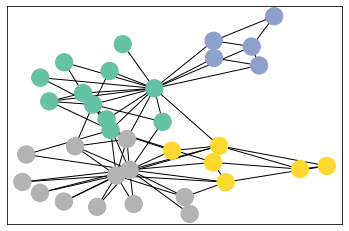

In [4]:
G = to_networkx(data, to_undirected=True)

nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,node_color=data.y, cmap="Set2")

In [5]:
# no features, just node ids

data.x = torch.arange(data.num_nodes) # node idx

In [6]:
torch.arange(data.num_nodes)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [7]:
from torch_geometric.nn.models import GAE # Graph Autoencoder
from torch_geometric.nn import GCNConv

In [8]:
class ConvEncoder(nn.Module):
    
    def __init__(self, num_nodes, embedding_dim):
        
        super().__init__()
        
        self.emb = nn.Embedding(num_nodes, embedding_dim)
        
        self.conv = GCNConv(embedding_dim, embedding_dim)
        
    def forward(self, x, edge_index):
        
        x = self.emb(x) # [batch_size, dim]
        
        return self.conv(x, edge_index) # [batch_size, dim]

In [9]:
class ConvGAE(nn.Module):
    
    def __init__(self, num_nodes, embedding_dim):

        super().__init__()

        # GAE decoder is dot product by default
        self.gae = GAE(
            encoder=ConvEncoder(num_nodes, embedding_dim),
            decoder=None
        )
    
    @torch.no_grad()
    def get_embeddings(self, x, edge_index):

        return self.gae.encode(x, edge_index).numpy()

    def visualize(self, x, edge_index):

        """visulize embeddings with PCA"""

        node_embeddings = self.get_embeddings(x, edge_index)

        node_cmp = PCA(n_components=2).fit_transform(node_embeddings)

        y = data.y.numpy()

        plt.scatter(node_cmp[:, 0], node_cmp[:, 1], s=140, c=y, cmap="Set2")

        plt.show()

    def train_model(self, x, edge_index, n_steps, opt):

        """train model given x, edge_index, n_steps and opt"""

        for i in tqdm(range(n_steps)):
            
            if i % 100 == 0:

                print(f'epoch={i}')

                self.visualize(x, edge_index)

            z = self.gae.encode(x, edge_index)

            loss = self.gae.recon_loss(z, edge_index)

            loss.backward()

            opt.step()

            opt.zero_grad()

In [10]:
model = ConvGAE(data.num_nodes, 16)

opt = torch.optim.SGD(model.parameters(), lr=0.5, weight_decay=0.01)

  0%|          | 0/500 [00:00<?, ?it/s]

epoch=0


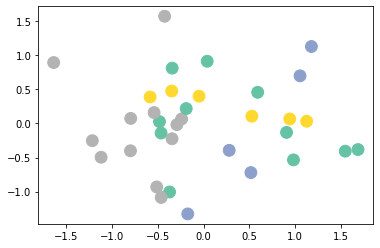

/home/urchade.zaratiana/.local/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
 17%|█▋        | 83/500 [00:00<00:01, 308.96it/s]

epoch=100


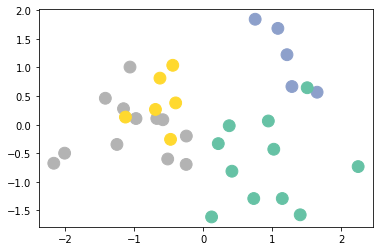

 39%|███▉      | 197/500 [00:00<00:00, 320.41it/s]

epoch=200


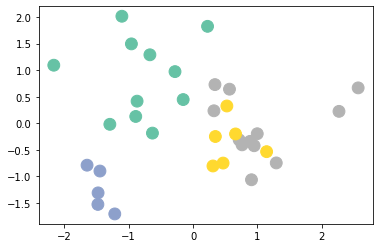

 55%|█████▍    | 273/500 [00:00<00:00, 304.57it/s]

epoch=300


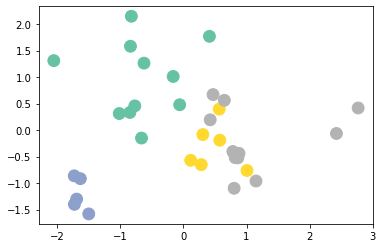

 78%|███████▊  | 389/500 [00:01<00:00, 322.87it/s]

epoch=400


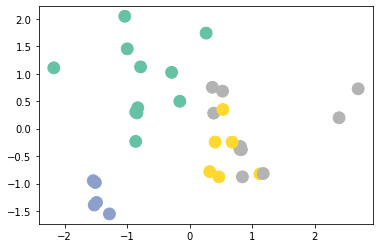

100%|██████████| 500/500 [00:01<00:00, 285.47it/s]


In [11]:
model.train_model(data.x, data.edge_index, 500, opt)